# Проектная работа по дисциплине "Теория обнаружения вторжений с применением искусственного интеллекта"

#### Тема проекта: "Обнаружение фишинговых сообщений с помощью нейронных сетей"
#### Команда, работающая над проектом, представлена группой студентов:
- **ББМО-02-22 Кузьмин Владимир Дмитриевич**
- ББМО-02-22 Исаев Александр Михайлович
- ББМО-01-22 Загороднов Егор Алексеевич
- ББМО-01-22 Карев Даниил Павлович

# Актуальность
В 2022 году количество фишинговых атак заметно выросло. Система «Антифишинг» пресекла 507 851 735 попыток перехода по фишинговым ссылкам – это примерно вдвое больше, чем в 2021-м.

В последнее время мы наблюдаем увеличение количества целевых фишинговых атак, при которых мошенники переходят к самой фишинговой атаке не сразу, а после нескольких «ознакомительных» писем, в которых активно переписываются с жертвой. Скорее всего, эта тенденция продолжится. Также вероятно появление в 2023 году новых уловок в корпоративном секторе, атаки на который приносят злоумышленникам значительную прибыль [1].

С января по апрель 2022 года защитные решения "Лаборатории Касперского" заблокировали более 800 тысяч фишинговых писем на русском языке с вредоносными HTML-вложениями, почти половину из них - в марте. Такой метод представляет собой продвинутый с технической точки зрения и распространенный прием для выманивания данных пользователей, в том числе платежных [2]. 

# Объект и предмет исследования
Объектом исследования данной работы является классификация фишинговых сообщений. Предметом исследования является создание и обучение нейронной сети для классификации фишинговых сообщений.

# Методы исследования
В ходе работы над проектом будут использованы такие методы исследования, как эмпирические, так и теоретические.

# Цель и задачи
Таким образом, цель данной работы – обнаружение фишинговых сообщений с помощью нейронных сетей.
Для достижения поставленной цели необходимо выполнить следующие задачи:

1. Подготовить данные для обучения;
1. Предобработать данные;
1. Подготовить наборы для обучения и тестирования;
1. Произвести обучение;
1. Обработать данные результатов обучения;
1. Протестировать обученную модель;
1. Повторить предыдущие этапы для различных моделей;
1. Выбрать наилучшую модель для достижения цели работы.

# Основная часть
#### Для обучения и тестирования модели будут использованы следующие датасеты:
- Nazario (фишинговые сообщения);
- Enron (легитимные сообщения).
#### Признаки, на основе которых будет происходить обучение моделей:
- длина почты отправителя;
- количество точек в почте отправителя;
- количество тире в почте отправителя;
- количество специальных символов в почте отправителя;
- количество цифр в почте отправителя;
- количество поддоменов в почте отправителя;
- количество ссылок;
- количество точек в ссылках;
- количество тире в ссылках;
- количество специальных символов в ссылках;
- наличие IP-адреса в ссылках;
- количество IP-адресов в ссылках;
- количество https ссылок;
- количество вложений;
- класс;
- количество часто встречаемых слов в фишинговых сообщениях.

## Библиотеки
Импортируем необходимые библиотеки для предобработки данных

In [1]:
#при необходимости придется установить библиотеки
#%pip install keras
#%pip install tensorflow

In [2]:
import re
import os
import nltk
import string
import mailbox
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from email.header import decode_header
from nltk.tokenize import word_tokenize

## Предобработка
Предобработаем текст для дальнейшего обучения

Получаем датасеты с легитимными и фишинговыми письмами

In [3]:
phishing_emails = mailbox.mbox('./Datasets/nazario-phishing.mbox')
valid_emails = mailbox.mbox('./Datasets/enron-legal.mbox')

In [4]:
#загрузим стоп-слова
#nltk.download('stopwords') 
#загрузим символы пунктуации
#nltk.download('punkt')

Объявим класс, в котором будем парсить письма, разбивая их на части

In [5]:
class EmailParser:
    #зададим регулярные выражения для определения ссылок и адресов почты
    urlRegex = r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=;]*)'
    emailRegex = r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)'
    
    #конструктор класса
    def __init__(self, email):
        #получаем на вход письмо
        self.email = email
        #запускаем функцию разбиения письма на части
        self.__extract_email_parts()
    
    #функция разбиения письма на части
    def __extract_email_parts(self):
        #количество вложений
        no_of_attachments = 0
        #текст сообщения
        text = str(self.email['Subject']) + " "
        #html код сообщения
        htmlDoc = ""
        #проходимся по частям письма
        for part in self.email.walk():
            #определяем тип содержимого
            content_type = part.get_content_type()
            #если сообщение представлено обычным текстом
            if content_type == 'text/plain':
                #записываем в текст
                text += str(part.get_payload())
            #если сообщение представлено html кодом
            elif content_type == 'text/html':
                #записываем в html
                htmlDoc += part.get_payload()
            #в остальных случаях
            else:
                #смотрим основной тип содержимого
                main_content_type = part.get_content_maintype()
                #если представлен изображением или приложением
                if main_content_type in ['image','application']:
                    #считаем как вложение
                    no_of_attachments += 1
        #передаем полученные значения в переменные класса
        self.text, self.html, self.no_of_attachments = text, htmlDoc, no_of_attachments
    
    #ищем ссылки
    def get_urls(self):
        #регулярным выражением выуживаем ссылки из текст сообщения
        text_urls = set(re.findall(EmailParser.urlRegex,self.text))
        #и из html-кода
        html_urls = set(re.findall(EmailParser.urlRegex,self.html))
        #возвращаем результат в виде списка найденных ссылок
        return list(text_urls.union(html_urls))
    
    #получаем текст сообщения
    def get_email_text(self):
        #если письмо несет в себе тип html-кода
        if(self.html != ""):
            #парсим код классом BeautifulSoup
            soup = BeautifulSoup(self.html)
            #выуживаем текст из кода
            self.text += soup.text
        #возвращаем результат собранного текста
        return self.text
    
    #функция, возвращающая количество вложений
    def get_no_of_attachments(self):
        return self.no_of_attachments
    
    #получаем почту отправителя
    def get_sender_email_address(self):
        sender = email['From']
        try:
            #пытаемся регулярным выражением выудить почту отправителя
            emails = re.findall(EmailParser.emailRegex, sender)
        except:
            #если регуляркой не вышло, пробуем через байтовое представление
            h = decode_header(email['From'])
            header_bytes = h[0][0]
            sender = header_bytes.decode('ISO-8859-1')
            emails = re.findall(EmailParser.emailRegex, sender)
        #возвращаем результат
        if(len(emails) != 0):
            return emails[len(emails)-1]
        else:
            return ''

Объявим класс, в котором будем обрабатывать текст сообщения

In [6]:
class StringUtil:
    #объявим регулярные выражения для выуживания
    #точек
    dotRegex = r'\.'
    #цифр
    digitsRegex = r'[0-9]'
    #ip-адресов
    ipAddressRegex = r'(?:[0-9]{1,3}\.){3}[0-9]{1,3}'
    #тире
    dashesRegex = r'-'
    #специальных символов
    specialCharsRegex = r'[()@:%_\+~#?\=;]'
    
    #объявим счетчик слов
    words = Counter()
    #зафиксируем стоп-слова для английского языка
    stop_words = set(stopwords.words('english'))
    #инициализируем класс Портера Стеммера
    stemmer = nltk.PorterStemmer()
    #выделим символы пунктуации
    #punctuations = ['!','@','#','$','%','^','&','*','(',')','-','_','=','+',';',':',"'",'"','?','/','<','>','.',',','/','~','`']
    
    #объявим функцию обработки ссылок
    def process_urls(self,urls):
        #объявим переменные, которые будут нашими признаками
        noOfDots, noOfDashes, noOfSpecialChars, hasIpAddressInUrl, noOfIpAddress, noOfHttpsLinks = 0,0,0,0,0,0
        #обрабатываем все ссылки
        for url in urls:
            #если ссылка начинается с https://
            if url.startswith('https://'):
                #считаем ссылки
                noOfHttpsLinks += 1
            #считаем количетсво точек
            noOfDots += len(re.findall(StringUtil.dotRegex,url))
            #считаем количество тире
            noOfDashes += len(re.findall(StringUtil.dashesRegex,url))
            #считаем количество специальных символов
            noOfSpecialChars += len(re.findall(StringUtil.specialCharsRegex,url))
            #считаем количество ip-адресов
            noOfIpAddress += len(re.findall(StringUtil.ipAddressRegex, url))
        #если ip-адреса были найдены
        if noOfIpAddress > 0:
            #фиксируем наличие ip-адресов в ссылках
            hasIpAddressInUrl = 1
        #возвращаем собранные признаки
        return len(urls), noOfDots, noOfDashes, noOfSpecialChars, hasIpAddressInUrl, noOfIpAddress, noOfHttpsLinks
    
    #объявим функцию обработки текста
    def process_text(self, text):
        #приведем текст в нижнему регистру
        text = text.lower()
        #удалим из текста символы переноса курсора
        text = re.sub(r'[\n\t\r]', ' ', text)
        
        #удаляем пунктуацию
        punctuation = string.punctuation  #получаем все символы пунктуации
        translator = str.maketrans('', '', punctuation + string.digits)  #создаем транслятор
        text = text.translate(translator)  #удаляем пунктуацию и цифры транслятором

        #выделим токены из текста
        word_tokens = word_tokenize(text)
        filtered_text = []
        for w in word_tokens:
            #исключим стоп-слова
            if w not in StringUtil.stop_words:
                filtered_text.append(w)
        
        #счетчик частоты слов
        word_counts = Counter(filtered_text)
        stemmed_word_count = Counter()
        for word, count in word_counts.items():
            #обрабатываем каждое слово алгоритмом стемминга
            stemmed_word = StringUtil.stemmer.stem(word)
            #считаем количество таких слов
            stemmed_word_count[stemmed_word] += count
        word_counts = stemmed_word_count
        StringUtil.words += word_counts
        return word_counts
    
    #объявим функцию обработки почты отправителя
    def process_email_address(self, emailid):
        #объявим переменные, которые будут нашими признаками
        length, noOfDots, noOfDashes, noOfSpecialChars, noOfDigits, noOfSubdomains = 0,0,0,0,0,0
        
        #определяем длину почты
        length = len(emailid)
        #если длина почты больше 0
        if(length > 0):
            #фиксируем пользователя и почтовый домен
            username, domain = emailid.split('@')
            #считаем количество поддоменов
            noOfSubdomains = len(re.findall(StringUtil.dotRegex,domain)) - 1
            #считаем количество точек
            noOfDots = len(re.findall(StringUtil.dotRegex, username))
            #считаем количество специальных символов
            noOfSpecialChars = len(re.findall(StringUtil.specialCharsRegex, username))
            #считаем количество тире
            noOfDashes = len(re.findall(StringUtil.dashesRegex, emailid))
            #считаем количество цифр
            noOfDigits = len(re.findall(StringUtil.digitsRegex, emailid))
        #возвращаем полученные признаки
        return length, noOfDots, noOfDashes, noOfSpecialChars, noOfDigits, noOfSubdomains
    
    #функция, возвращающая 1000 самый часто встречаемых слов
    def get_most_common_words(self):
        return StringUtil.words.most_common(1000)

Определим первый датафрейм из фишинговых сообщений

In [7]:
df1 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpsLinks','no_of_attachments','class_label'])
stringUtil = StringUtil()

for email in phishing_emails:
    #парсим каждое фишинговое письмо
    emailParser = EmailParser(email)
    #определяем количество вложений
    no_of_attachments = emailParser.get_no_of_attachments()
    #определяем признаки почты отправителя
    emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
    #определяем признаки ссылок
    urls_features = stringUtil.process_urls(emailParser.get_urls())
    #выделяем количество слов стемминга
    word_dict = stringUtil.process_text(emailParser.get_email_text())
    #заполняем датафрейм
    df1.loc[len(df1)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, 1]

#определяем самые часто встречаемые слова из фишинговых сообщений
malicious_words = stringUtil.get_most_common_words()

Взглянем на содержимое датафрейма

In [8]:
df1.head()

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,class_label
0,"{'import': 1, 'account': 1, 'notic': 1, 'south...",29,0,0,1,3,0,2,5,0,2,1,1,1,1,1
1,"{'ebay': 9, 'account': 4, 'verif': 1, 'dear': ...",21,0,0,0,0,0,2,5,1,9,0,0,0,0,1
2,"{'ebay': 2, 'account': 4, 'verif': 1, 'dear': ...",21,0,0,0,0,0,2,6,1,8,0,0,0,0,1
3,"{'keybank': 2, 'custom': 2, 'confirm': 4, 'ide...",19,0,0,0,0,0,3,8,0,6,1,1,1,0,1
4,"{'keybank': 2, 'custom': 2, 'confirm': 4, 'ide...",19,0,0,0,0,0,3,8,0,6,1,1,1,0,1


Определим второй датафрейм из легитимных сообщений

In [9]:
df2 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpsLinks','no_of_attachments','class_label'])
stringUtil = StringUtil()

for email in valid_emails:
    #парсим каждое легитимное письмо
    emailParser = EmailParser(email)
    #определяем количество вложений
    no_of_attachments = emailParser.get_no_of_attachments()
    #определяем признаки почты отправителя
    emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
    #определяем признаки ссылок
    urls_features = stringUtil.process_urls(emailParser.get_urls())
    #выделяем количество слов стемминга
    word_dict = stringUtil.process_text(emailParser.get_email_text())
    #заполняем датафрейм
    df2.loc[len(df2)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, 0]

Взглянем на содержимое датафрейма

In [10]:
df2.head()

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,class_label
0,"{'pay': 2, 'well': 1, 'perform': 1, 'bonus': 1...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"{'trade': 2, 'profit': 1, 'p': 1, 'allen': 1, ...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"{'bonu': 2, 'expect': 1, 'confidenti': 1, 'joh...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"{'trade': 2, 'profit': 1, 'p': 1, 'allen': 1, ...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"{'pay': 2, 'well': 1, 'perform': 1, 'bonus': 1...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Объединяем датафреймы в общий набор

In [11]:
df = pd.concat([df1,df2],axis=0)

Заменим признак "текст" на признак "самые часто встречаемые слова в фишинговых сообщениях"

In [12]:
df['noOfMaliciousWords'] = df['text'].apply(lambda x: len(set(x.keys()).intersection(set(dict(malicious_words).keys()))))
df = df.drop(columns=['text'])

Взглянем на содержимое датафрейма

In [13]:
df.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,class_label,noOfMaliciousWords
0,29,0,0,1,3,0,2,5,0,2,1,1,1,1,1,6
1,21,0,0,0,0,0,2,5,1,9,0,0,0,0,1,46
2,21,0,0,0,0,0,2,6,1,8,0,0,0,0,1,28
3,19,0,0,0,0,0,3,8,0,6,1,1,1,0,1,70
4,19,0,0,0,0,0,3,8,0,6,1,1,1,0,1,70


Посмотрим на статистику датафрейма

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6558 entries, 0 to 4278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            6558 non-null   int64
 1   noOfDotsInEmailId          6558 non-null   int64
 2   noOfDashesInEmailId        6558 non-null   int64
 3   noOfSpecialCharsInEmailId  6558 non-null   int64
 4   noOfDigitsInEmailId        6558 non-null   int64
 5   noOfSubdomainsInEmailId    6558 non-null   int64
 6   noOfUrls                   6558 non-null   int64
 7   noOfDotsInUrls             6558 non-null   int64
 8   noOfDashesInUrls           6558 non-null   int64
 9   noOfSpecialCharsInUrls     6558 non-null   int64
 10  hasIpAddressInUrls         6558 non-null   int64
 11  noOfIpAddressInUrls        6558 non-null   int64
 12  noOfHttpsLinks             6558 non-null   int64
 13  no_of_attachments          6558 non-null   int64
 14  class_label             

Ради оптимизации приведем значения датафрейма к типу данных int16

In [15]:
df = df.astype('int16')

Посмотрим статистику

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6558 entries, 0 to 4278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            6558 non-null   int16
 1   noOfDotsInEmailId          6558 non-null   int16
 2   noOfDashesInEmailId        6558 non-null   int16
 3   noOfSpecialCharsInEmailId  6558 non-null   int16
 4   noOfDigitsInEmailId        6558 non-null   int16
 5   noOfSubdomainsInEmailId    6558 non-null   int16
 6   noOfUrls                   6558 non-null   int16
 7   noOfDotsInUrls             6558 non-null   int16
 8   noOfDashesInUrls           6558 non-null   int16
 9   noOfSpecialCharsInUrls     6558 non-null   int16
 10  hasIpAddressInUrls         6558 non-null   int16
 11  noOfIpAddressInUrls        6558 non-null   int16
 12  noOfHttpsLinks             6558 non-null   int16
 13  no_of_attachments          6558 non-null   int16
 14  class_label             

Сохраним датафрейм, чтобы больше не тратить время на предобработку данных

In [17]:
df.to_csv("./Data/data.csv", sep=',')

## Обучение

✔️Можем теперь начинать компиляцию отсюда (Необходимо лишь импортировать библиотеки в начале проекта)

Загружаем обработанный датафрейм

In [18]:
df = pd.read_csv("./Data/data.csv").drop('Unnamed: 0', axis=1)
df.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,class_label,noOfMaliciousWords
0,29,0,0,1,3,0,2,5,0,2,1,1,1,1,1,6
1,21,0,0,0,0,0,2,5,1,9,0,0,0,0,1,46
2,21,0,0,0,0,0,2,6,1,8,0,0,0,0,1,28
3,19,0,0,0,0,0,3,8,0,6,1,1,1,0,1,70
4,19,0,0,0,0,0,3,8,0,6,1,1,1,0,1,70


Импортируем библиотеки для обучения

In [19]:
#модуль для разбиения датасета на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

#модель случайные леса
from sklearn.ensemble import RandomForestClassifier
#модель адабуст
from sklearn.ensemble import AdaBoostClassifier
#модель к-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
#модель бэггинга
from sklearn.ensemble import BaggingClassifier
#модель ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier
#модель дерева решений
from sklearn.tree import DecisionTreeClassifier
#модель логистической регрессии
from sklearn.linear_model import LogisticRegression
#модель опорных векторов
from sklearn.svm import SVC
#модель наивного байеса
from sklearn.naive_bayes import MultinomialNB
#многослойный персептрон
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM

#метрики для моделей
from sklearn.metrics import accuracy_score, precision_score

#модуль выбора классификатора
from sklearn.ensemble import VotingClassifier

#библиотека визуализации
import matplotlib.pyplot as plt

#библиотека для сохранения и загрузки моделей
import joblib

Разобьем датафрейм на обучающую и тестовую выборки

In [20]:
x = df.drop(columns=["class_label"]).values
y = df["class_label"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=34, test_size=0.2)

#### Обучим набор классификаторов

Инициализируем модели

In [21]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Зафиксируем их в виде словаря

In [22]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Объявим функции обучения и классификации

In [23]:
#объявим функцию обучения классификаторов
def train_classifier(clf, x_train, y_train):    
    clf.fit(x_train, y_train)

In [24]:
#объявим функцию классификации
def predict_labels(clf, x):
    return (clf.predict(x))

Обучим и оценим классификаторы

In [25]:
pred_dict={}
#пробежимся по классификаторам
for k,v in clfs.items():
    #обучаем классификатор
    train_classifier(v, x_train, y_train)
    #сохраняем обученную модель
    joblib.dump(v, './Models/' + k + '.pkl')
    #классифицируем тестовые выборки
    pred = predict_labels(v,x_test)
    #записываем точность классификатора
    pred_dict[k]=[accuracy_score(y_test,pred)]

✔️Можем теперь пропустить этап обучения набора классификаторов и загрузить их из файла

In [26]:
clfs={}
classifiers = ['SVC','KN', 'NB', 'DT', 'LR', 'RF', 'AdaBoost', 'BgC', 'ETC']
pred_dict={}
#пробежимся по классификаторам
for k in classifiers:
    #загрузим из файла обученную модель
    clfs[k]=joblib.load('./Models/' + k + '.pkl')
    #классифицируем тестовые выборки
    pred = clfs[k].predict(x_test)
    #записываем точность классификатора
    pred_dict[k]=[accuracy_score(y_test,pred)]

Сформируем результирующую таблицу

In [27]:
#объявляем датафрейм на основе собранной статистики по классификаторам
res = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
res

,Score
SVC,0.669970
KN,0.938262
NB,0.936738
DT,0.962652
LR,0.951982
RF,0.975610
AdaBoost,0.964939
BgC,0.974085
ETC,0.972561


Визуализируем результаты

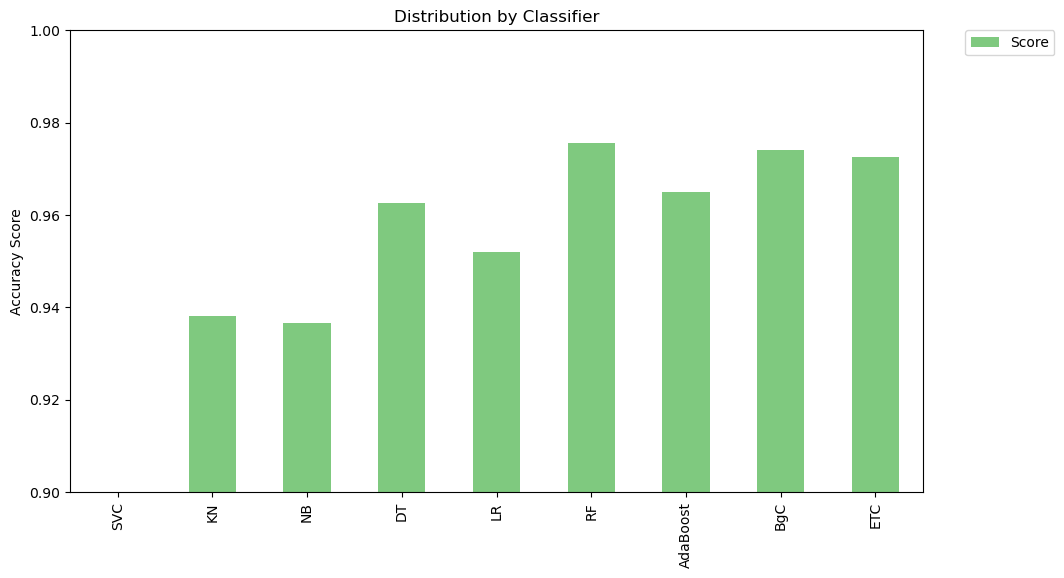

In [28]:
res.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), res.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Обучим персептрон

In [29]:
#настроим персептрон
mlp_model = Sequential()
mlp_model.add(Dense(512, input_shape=(df.shape[1]-1,)))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(2))
mlp_model.add(Activation('softmax'))

mlp_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print(mlp_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               8192      
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 9,218
Trainable params: 9,218
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
#обучаем модель
mlp_history = mlp_model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
164/164 [==============================] - 1s 2ms/step - loss: 0.5737 - acc: 0.8679 - val_loss: 0.1592 - val_acc: 0.9505
Epoch 2/10
164/164 [==============================] - 0s 970us/step - loss: 0.2551 - acc: 0.9323 - val_loss: 0.1518 - val_acc: 0.9512
Epoch 3/10
164/164 [==============================] - 0s 1ms/step - loss: 0.2338 - acc: 0.9361 - val_loss: 0.1124 - val_acc: 0.9596
Epoch 4/10
164/164 [==============================] - 0s 989us/step - loss: 0.2036 - acc: 0.9422 - val_loss: 0.1073 - val_acc: 0.9634
Epoch 5/10
164/164 [==============================] - 0s 964us/step - loss: 0.1599 - acc: 0.9493 - val_loss: 0.0990 - val_acc: 0.9695
Epoch 6/10
164/164 [==============================] - 0s 982us/step - loss: 0.1357 - acc: 0.9535 - val_loss: 0.1576 - val_acc: 0.9337
Epoch 7/10
164/164 [==============================] - 0s 952us/step - loss: 0.1491 - acc: 0.9516 - val_loss: 0.1124 - val_acc: 0.9604
Epoch 8/10
164/164 [==============================] - 0s 989us/ste

In [31]:
#сохраняем обученную модель
joblib.dump(mlp_model, './Models/MLP.pkl')

['./Models/MLP.pkl']

✔️Можем теперь пропустить этап обучения персептрона и загрузить его из файла

In [32]:
#загрузим из файла обученную модель
mlp_model=joblib.load('./Models/MLP.pkl')

In [33]:
#валидируем
score = mlp_model.evaluate(x_test, y_test, batch_size=32, verbose=1)
print(u'loss: {}'.format(score[0]))
print(u'accuracy: {}'.format(score[1]))

41/41 [==============================] - 0s 676us/step - loss: 0.0991 - acc: 0.9680
loss: 0.09913115203380585
accuracy: 0.9679877758026123


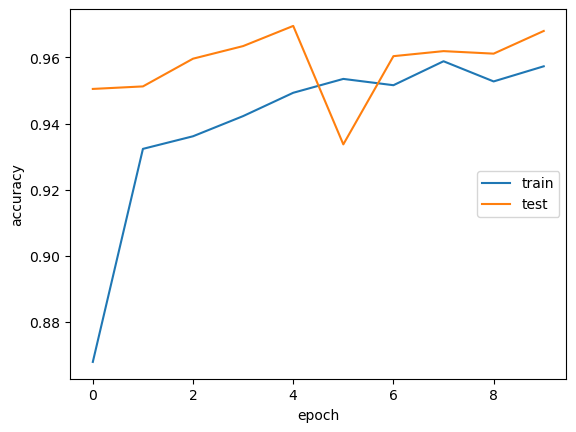

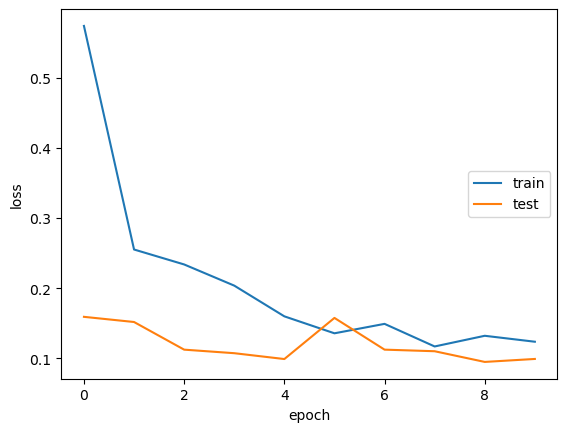

In [34]:
#график точности модели
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()
#график потерь модели
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

#### Обучим LSTM модель

In [35]:
#настроим модель
lstm_model = Sequential()
lstm_model.add(Embedding(df.shape[0], df.shape[0]))
lstm_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(2, activation='sigmoid'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print (lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 6558)        43007364  
                                                                 
 lstm (LSTM)                 (None, 32)                843648    
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 43,851,078
Trainable params: 43,851,078
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
#обучаем LSTM
lstm_history = lstm_model.fit(x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
164/164 [==============================] - 77s 461ms/step - loss: 0.1802 - accuracy: 0.9258 - val_loss: 0.1044 - val_accuracy: 0.9611
Epoch 2/3
164/164 [==============================] - 74s 453ms/step - loss: 0.1022 - accuracy: 0.9619 - val_loss: 0.1241 - val_accuracy: 0.9604
Epoch 3/3
164/164 [==============================] - 77s 470ms/step - loss: 0.0867 - accuracy: 0.9649 - val_loss: 0.0945 - val_accuracy: 0.9642


In [37]:
#сохраняем обученную модель
joblib.dump(lstm_model, './Models/LSTM.pkl')

['./Models/LSTM.pkl']

✔️Можем теперь пропустить этап обучения LSTM модели и загрузить ее из файла

In [38]:
#загрузим из файла обученную модель
lstm_model=joblib.load('./Models/LSTM.pkl')

In [39]:
#валидируем
score = lstm_model.evaluate(x_test, y_test, batch_size=32, verbose=1)
print()
print(u'loss: {}'.format(score[0]))
print(u'accuracy: {}'.format(score[1]))

41/41 [==============================] - 1s 18ms/step - loss: 0.0945 - accuracy: 0.9642

loss: 0.09452326595783234
accuracy: 0.9641768336296082


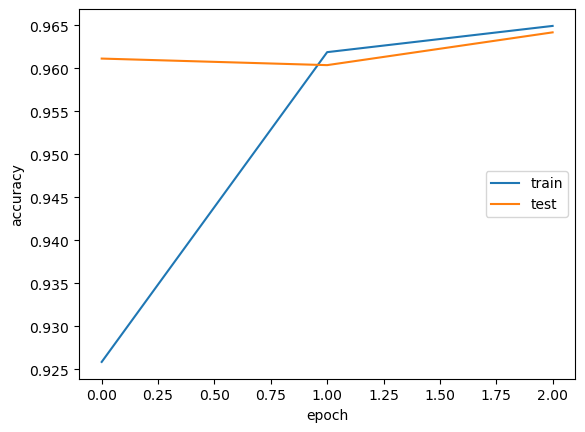

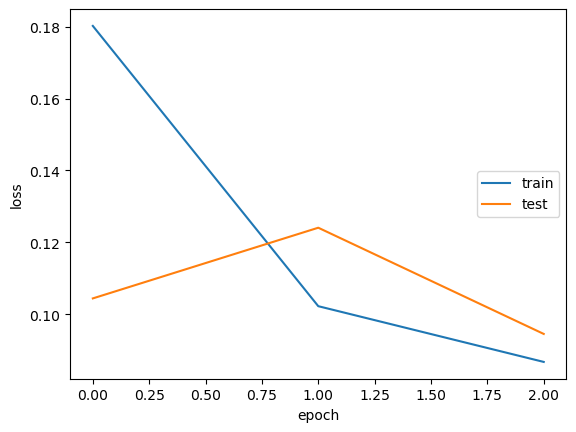

In [40]:
#график точности модели
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()
#график потерь модели
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

## Тестирование

Попробуем протестировать модели на дополнительных датасетах

In [41]:
#загружаем три дополнительных датасета
bonus_phishing_emails = [mailbox.mbox('./Datasets/phishing0.mbox'), 
                        mailbox.mbox('./Datasets/phishing1.mbox'), 
                        mailbox.mbox('./Datasets/phishing2.mbox')]

df3 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpsLinks','no_of_attachments','class_label'])
stringUtil = StringUtil()
for emails in bonus_phishing_emails:
    for email in emails:
        #парсим каждое фишинговое письмо
        emailParser = EmailParser(email)
        #определяем количество вложений
        no_of_attachments = emailParser.get_no_of_attachments()
        #определяем признаки почты отправителя
        emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
        #определяем признаки ссылок
        urls_features = stringUtil.process_urls(emailParser.get_urls())
        #выделяем количество слов стемминга
        word_dict = stringUtil.process_text(emailParser.get_email_text())
        #заполняем датафрейм
        df3.loc[len(df3)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, 1]

#определяем самые часто встречаемые слова из фишинговых сообщений
malicious_words = stringUtil.get_most_common_words()

#заменим признак "текст" на признак "самые часто встречаемые слова из фишинговых сообщений"
df3['noOfMaliciousWords'] = df3['text'].apply(lambda x: len(set(x.keys()).intersection(set(dict(malicious_words).keys()))))
df3 = df3.drop(columns=['text'])

df3.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,class_label,noOfMaliciousWords
0,19,0,1,0,0,0,7,24,5,8,1,1,0,0,1,79
1,20,0,1,0,0,0,14,41,9,16,0,0,0,0,1,127
2,20,0,0,0,1,1,71,305,2,94,0,0,0,0,1,102
3,25,0,1,0,0,0,1,4,0,2,1,1,0,0,1,30
4,19,0,1,0,0,0,18,55,4,59,0,0,0,0,1,63


In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            2293 non-null   int64
 1   noOfDotsInEmailId          2293 non-null   int64
 2   noOfDashesInEmailId        2293 non-null   int64
 3   noOfSpecialCharsInEmailId  2293 non-null   int64
 4   noOfDigitsInEmailId        2293 non-null   int64
 5   noOfSubdomainsInEmailId    2293 non-null   int64
 6   noOfUrls                   2293 non-null   int64
 7   noOfDotsInUrls             2293 non-null   int64
 8   noOfDashesInUrls           2293 non-null   int64
 9   noOfSpecialCharsInUrls     2293 non-null   int64
 10  hasIpAddressInUrls         2293 non-null   int64
 11  noOfIpAddressInUrls        2293 non-null   int64
 12  noOfHttpsLinks             2293 non-null   int64
 13  no_of_attachments          2293 non-null   int64
 14  class_label             

Оптимизируем типы данных

In [43]:
df3 = df3.astype('int16')
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            2293 non-null   int16
 1   noOfDotsInEmailId          2293 non-null   int16
 2   noOfDashesInEmailId        2293 non-null   int16
 3   noOfSpecialCharsInEmailId  2293 non-null   int16
 4   noOfDigitsInEmailId        2293 non-null   int16
 5   noOfSubdomainsInEmailId    2293 non-null   int16
 6   noOfUrls                   2293 non-null   int16
 7   noOfDotsInUrls             2293 non-null   int16
 8   noOfDashesInUrls           2293 non-null   int16
 9   noOfSpecialCharsInUrls     2293 non-null   int16
 10  hasIpAddressInUrls         2293 non-null   int16
 11  noOfIpAddressInUrls        2293 non-null   int16
 12  noOfHttpsLinks             2293 non-null   int16
 13  no_of_attachments          2293 non-null   int16
 14  class_label             

Сохраним обработанный тестовый набор

In [44]:
df3.to_csv("./Data/data_test.csv", sep=',')

Загружаем датасет с файла

In [45]:
df3 = pd.read_csv("./Data/data_test.csv").drop('Unnamed: 0', axis=1)
df.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,class_label,noOfMaliciousWords
0,29,0,0,1,3,0,2,5,0,2,1,1,1,1,1,6
1,21,0,0,0,0,0,2,5,1,9,0,0,0,0,1,46
2,21,0,0,0,0,0,2,6,1,8,0,0,0,0,1,28
3,19,0,0,0,0,0,3,8,0,6,1,1,1,0,1,70
4,19,0,0,0,0,0,3,8,0,6,1,1,1,0,1,70


In [46]:
pred_dict={}
# пробежимся по классификаторам
for k,v in clfs.items():
    # классифицируем тестовые выборки
    pred = predict_labels(v,np.array(df3.drop(columns='class_label')))
    # записываем точность классификатора
    pred_dict[k]=[accuracy_score(np.array(df3['class_label']),pred)]

#персептрон
mlp_score = mlp_model.evaluate(np.array(df3.drop(columns='class_label')), np.array(df3['class_label']), batch_size=32, verbose=1)    
pred_dict['MLP']=[mlp_score[1],]

#lstm
lstm_score = lstm_model.evaluate(np.array(df3.drop(columns='class_label')), np.array(df3['class_label']), batch_size=32, verbose=1)    
pred_dict['LSTM']=[lstm_score[1],]

# объявляем датафрейм на основе собранной статистики по классификаторам
res = pd.DataFrame.from_dict(pred_dict, orient='index', columns=['Score'])

res

72/72 [==============================] - 1s 17ms/step - loss: 0.2659 - accuracy: 0.8993


,Score
SVC,0.000436
KN,0.793720
NB,0.802442
DT,0.885303
LR,0.834278
RF,0.937200
AdaBoost,0.911470
BgC,0.912778
ETC,0.922372
MLP,0.920628


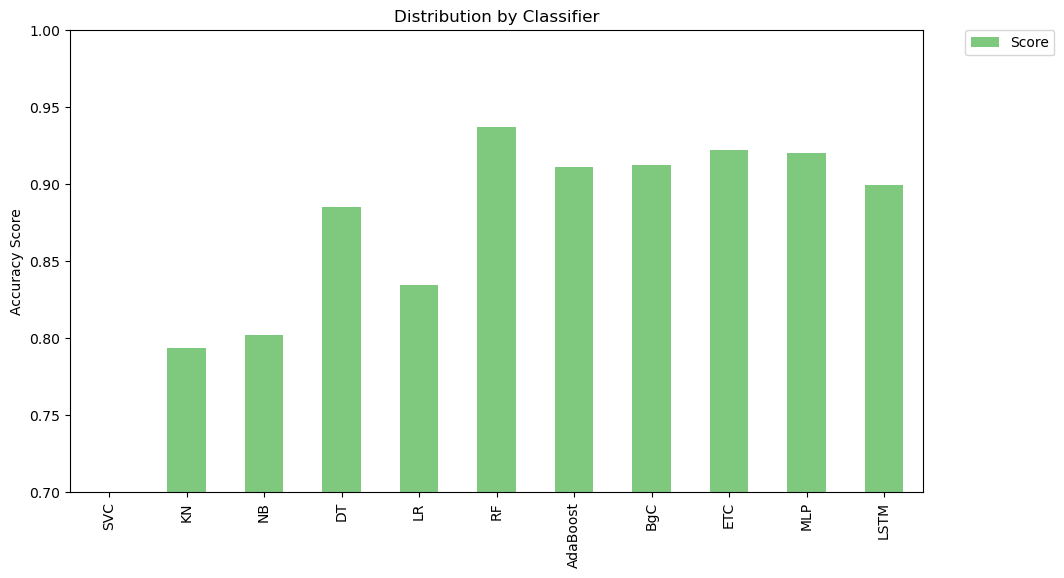

In [47]:
#визуализируем
res.plot(kind='bar', ylim=(0.7,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(res.shape[0]), res.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

По полученным результатам можем выделить алгоритм Random Forest как победителя в номинации лучший классификатор фишинговых сообщений (с учётом обучающих данных и выделенных признаков).

# Оптимизация гиперпараметров модели RF

Есть несколько способов определить, какие гиперпараметры следуюет насторить для нашей модели. Хороший способ визуально оценить потенциальные оптимизированные значения гиперпараметров модели — использовать кривую проверки. Кривая проверки может быть построена на графике, чтобы показать, насколько хорошо модель работает с различными значениями одного гиперпараметра.

Воссоздадим набор данных для обучения

In [48]:
from sklearn import model_selection
df = pd.read_csv("./Data/data.csv").drop('Unnamed: 0', axis=1)
x = df.drop(columns=["class_label"]).values
y = df["class_label"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=34, test_size=0.2)

Посчитаем оптимальный параметр n_estimators

In [49]:
num_est = np.arange(10, 210, 10)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                RandomForestClassifier(), 
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

Отобразим на графике

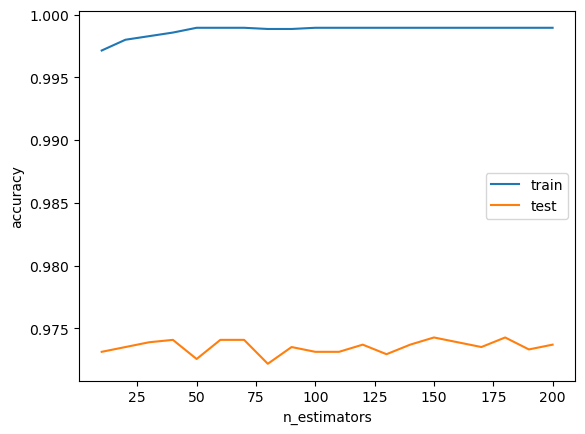

In [50]:
plt.plot(num_est, np.mean(train_scoreNum, axis = 1))
plt.plot(num_est, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Пиковое значение точности можем видеть при n_estimators в районе 150. Уточним значение

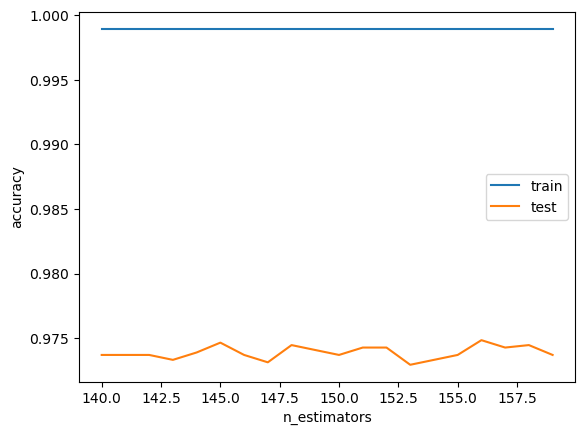

In [59]:
num_est = np.arange(140, 160, 1)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                RandomForestClassifier(), 
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

plt.plot(num_est, np.mean(train_scoreNum, axis = 1))
plt.plot(num_est, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Теперь явно видно, что пиковое значение точности достигается при **n_estimators = 156**. Зафиксируем данное значение.

Далее попробуем оценить оптимальное значение гиперпараметра max_depth

In [62]:
num_md = np.arange(10, 110, 10)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                RandomForestClassifier(n_estimators=156), 
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = num_md, cv = 3)

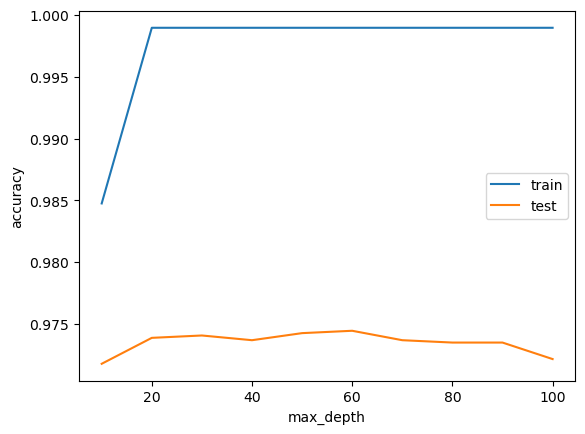

In [63]:
plt.plot(num_md, np.mean(train_scoreNum, axis = 1))
plt.plot(num_md, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'test'], loc='center right')
plt.show()

На данном графике оптимальное значение гиперпараметра max_depth наблюдается в районе 60. Уточним значение

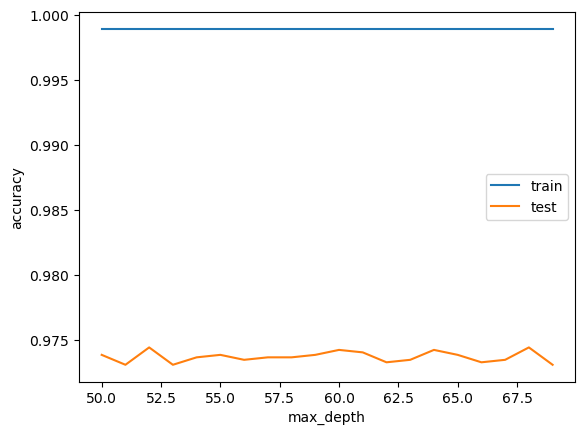

In [64]:
num_md = np.arange(50, 70, 1)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                RandomForestClassifier(n_estimators=156), 
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = num_md, cv = 3)

plt.plot(num_md, np.mean(train_scoreNum, axis = 1))
plt.plot(num_md, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Остановимся на значении **max_depth = 52**

Посмотрим оптимальное значение гиперпараметра bootstrap

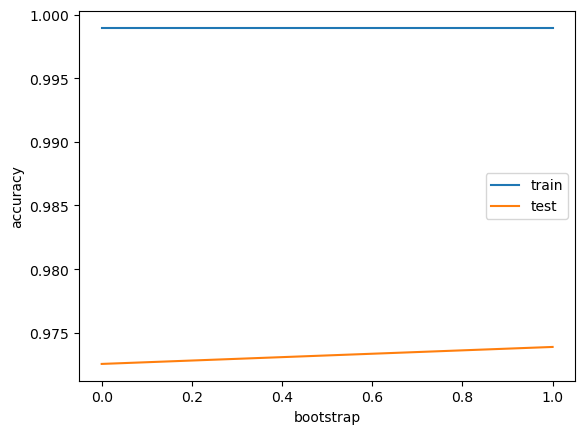

In [67]:
num_bs = np.array([False, True])
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                RandomForestClassifier(n_estimators=156, max_depth=52), 
                                X = x_train, y = y_train, 
                                param_name = 'bootstrap', 
                                param_range = num_bs, cv = 3)

plt.plot(num_bs, np.mean(train_scoreNum, axis = 1))
plt.plot(num_bs, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('bootstrap')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Значение точности выше при настройке **bootstrap = True**

Попробуем обучить модель с полученными значениями гиперпараметров и оценим результат

In [68]:
rf = RandomForestClassifier(n_estimators=156, max_depth=52, bootstrap=True, random_state=111)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
accuracy_score(y_test,rf_pred)

0.9763719512195121

Сравним полученное значение точности с точностью базовой модели

In [69]:
rfc = joblib.load('./Models/RF.pkl')
rfc_pred = rfc.predict(x_test)
accuracy_score(y_test,rfc_pred)

0.975609756097561

Мы смогли достичь небольшого прироста в точности. Попробуем сравнить на дополнительных тестовых наборах

In [70]:
df3 = pd.read_csv("./Data/data_test.csv").drop('Unnamed: 0', axis=1)
# классифицируем тестовые выборки
rf_pred = rf.predict(np.array(df3.drop(columns='class_label')))
rfc_pred = rfc.predict(np.array(df3.drop(columns='class_label')))
# запишем точность моделей
print('rf acc:', accuracy_score(np.array(df3['class_label']),rf_pred))
print('rfс acc:', accuracy_score(np.array(df3['class_label']),rfc_pred))

rf acc: 0.9341474051460968
rfс acc: 0.9372001744439599


Точность классификации на дополнительных наборах также показала небольшое преимущество

Можно сделать вывод о том, что базовая модель самостоятельно подбирает близкие к оптимальным гиперпараметры для модели. Поэтому явное указание гиперпараметров для повышения точности классификатора может дать небольшое преимущество.

Настройка гиперпараметров может быть полезна при создании модели, которая лучше подходит для классификации. В случае со случайным лесом в этом может не быть необходимости, так как случайные леса уже очень хорошо классифицируют. Использование исчерпывающего поиска по сетке для выбора значений гиперпараметров также может занять очень много времени. Однако в тех случаях, когда имеется только несколько потенциальных значений для ваших гиперпараметров или когда ваша исходная модель классификации не очень точна, может быть хорошей идеей, по крайней мере, исследовать влияние изменения некоторых значений гиперпараметров на вашу модель.

# Заключение

В ходе работы над проектом, по полученным результатам видно, что модель случайных лесов - лучший алгоритм для обнаружения фишинговых сообщений с учетом обучающего набора и выделяемых признаков. Точность 1 предполагает, что каждое нефишинговое письмо будет корректно идентифицировано и не попадет в папку со спамом, если это будет реализовано в реальном решении.

Алгоритм случайных лесов показал наивысший, среди других моделей, результат приблизительно равный 0,98. Соответственно, существует вероятность того, что небольшая часть фишинговых сообщений всё же попадет в почтовый ящик незамеченной. В случае со случайным лесом - 2 из 100 фишинговых писем останутся незамеченными.

Необходимость предобработки данных и выделения признаков для классификации может влиять на производительность.

Также нам удалось достичь лучших показателей точности выбранного классификатора путем подбора и явного указания гиперпараметров.

# Список используемых источников

1. Спам и фишинг в 2022 году // https://securelist.ru/ : сайт. - URL: https://securelist.ru/spam-phishing-scam-report-2022/106719/ (дата обращения: 20.03.2023);
1. Лаборатория Касперского" заблокировала 800 тыс. русских фишинговых писем в 2022 году // https://tass.ru/ : сайт. - URL: https://tass.ru/obschestvo/14635485 (дата обращения: 20.03.2023);
1. Искусственный интеллект: технологии и применение // https://rdc.grfc.ru/ : сайт. - URL: https://rdc.grfc.ru/2020/12/aitech/ (дата обращения: 20.03.2023);
1. Фишинговые письма // https://phishman.ru/ : сайт. - URL: https://phishman.ru/blog/phishing-emails (дата обращения: 20.03.2023);
1. Не дайте себя обмануть - 7 признаков фишинговых писем // https://vc.ru : сайт. - URL: https://vc.ru/services/119070-ne-dayte-sebya-obmanut-7-priznakov-fishingovyh-pisem (дата обращения: 20.03.2023);
1. Keras и Tensorflow - классификация текста // https://cloud.croc.ru/ : сайт. - URL: https://cloud.croc.ru/blog/about-technologies/keras-i-tensorflow-klassifikatsiya-teksta/ (дата обращения: 20.03.2023).